In [1]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd

### Downloading the data

In [2]:
%cd C:/Users/Manvir/OneDrive - UBC/UBC MDS/22.DSCI_525_web-cloud-comp_students/525_group_14

C:\Users\Manvir\OneDrive - UBC\UBC MDS\22.DSCI_525_web-cloud-comp_students\525_group_14


In [ ]:
article_id = 14096681
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "data/"

In [ ]:
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)  # this contains all the articles data, feel free to check it out
files = data["files"]             # this is just the data about the files, which is what we want
files

In [ ]:
%%time
files_to_dl = ["data.zip"]  # feel free to add other files here
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

In [ ]:
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory)

In [ ]:
pwd

In [ ]:
%ls -ltr data

## Combining the data

In [ ]:
%%time

## combining the data after moving the SYD data out of the folder


# df = pd.DataFrame()
files = os.listdir('data')
files = [file for file in files if ".csv" in file]

if "combined_data.csv" in files:
    print("removing old combined file")
    os.remove("data\\combined_data.csv")
    files.remove("combined_data.csv")

if "observed_daily_rainfall_SYD.csv" in files:
    print("moving observed_daily_rainfall_SYD.csv")
    os.replace("data\\observed_daily_rainfall_SYD.csv",
               "C:\\Users\\Manvir\\OneDrive - UBC\\UBC MDS\\22.DSCI_525_web-cloud-comp_students\\525_group_14\\observed_daily_rainfall_SYD.csv")
    files.remove("observed_daily_rainfall_SYD.csv")
    
df = pd.concat((pd.read_csv(f'data\\{file}', index_col=0)
                .assign(model=file.split("_")[0])
                for file in files)
              )
df.to_csv("data/combined_data.csv")

### Loading combined data to memory

##### 1. Reading only the necessary columns

In [3]:
%%time
use_cols = ['time','rain (mm/day)','model']
df = pd.read_csv("data/combined_data.csv",usecols=use_cols)
print(df["model"].value_counts())

MPI-ESM1-2-HR       5154240
TaiESM1             3541230
NorESM2-MM          3541230
CMCC-CM2-HR4        3541230
CMCC-CM2-SR5        3541230
CMCC-ESM2           3541230
SAM0-UNICON         3541153
FGOALS-f3-L         3219300
GFDL-CM4            3219300
GFDL-ESM4           3219300
EC-Earth3-Veg-LR    3037320
MRI-ESM2-0          3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM5-0           1609650
INM-CM4-8           1609650
KIOST-ESM           1287720
FGOALS-g3           1287720
MPI-ESM1-2-LR        966420
NESM3                966420
AWI-ESM-1-1-LR       966420
MPI-ESM-1-2-HAM      966420
NorESM2-LM           919800
BCC-ESM1             551880
CanESM5              551880
Name: model, dtype: int64
CPU times: total: 2min 17s
Wall time: 4min 16s


##### 2.Changing Data Types

In [5]:
print(f"Memory usage with rain as float64 and time as object: {df.memory_usage().sum() / 1e6:.2f} MB")

Memory usage with rain as float64 and time as object: 1499.23 MB


In [7]:
df['rain (mm/day)'] = df['rain (mm/day)'].astype('float32')
df['time'] = pd.to_datetime(df['time']).dt.date
print(f"Memory usage with rain as float32 and time as datetime object: {df.memory_usage().sum() / 1e6:.2f} MB")

Memory usage with rain as float32 and time as datetime object: 1249.36 MB


##### 3. Reading data in chunks

In [8]:
%%time
counts = pd.Series(dtype=int)
for chunk in pd.read_csv("data/combined_data.csv", chunksize=10_000_000):
    counts = counts.add(chunk["model"].value_counts(), fill_value=0)
print(counts.astype(int))

ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
AWI-ESM-1-1-LR       966420
BCC-CSM2-MR         3035340
BCC-ESM1             551880
CMCC-CM2-HR4        3541230
CMCC-CM2-SR5        3541230
CMCC-ESM2           3541230
CanESM5              551880
EC-Earth3-Veg-LR    3037320
FGOALS-f3-L         3219300
FGOALS-g3           1287720
GFDL-CM4            3219300
GFDL-ESM4           3219300
INM-CM4-8           1609650
INM-CM5-0           1609650
KIOST-ESM           1287720
MIROC6              2070900
MPI-ESM-1-2-HAM      966420
MPI-ESM1-2-HR       5154240
MPI-ESM1-2-LR        966420
MRI-ESM2-0          3037320
NESM3                966420
NorESM2-LM           919800
NorESM2-MM          3541230
SAM0-UNICON         3541153
TaiESM1             3541230
dtype: int32
CPU times: total: 2min 5s
Wall time: 2min 20s


### Transferring data from python to R

In [9]:
# !pip install rpy2_arrow
import pyarrow.dataset as ds
import pyarrow as pa
import pandas as pd
import pyarrow 
from pyarrow import csv
import rpy2_arrow.pyarrow_rarrow as pyra

In [10]:
%load_ext rpy2.ipython


C:\Users\Manvir\miniconda3\envs\525_2023\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [11]:
%%time
csv_data = ds.dataset('data/combined_data.csv', format="csv")
# Converting the `pyarrow dataset` to a `pyarrow table`
table = csv_data.to_table()
# Converting a `pyarrow table` to a `rarrow table`
r_table = pyra.converter.py2rpy(table)

CPU times: total: 47.8 s
Wall time: 48.9 s


#### EDA in R

In [20]:
# %%R
# install.packages('dplyr')
# install.packages('ggplot2')
# install.packages('forcats')

R[write to console]: Installing package into 'C:/Users/Manvir/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)



--- Please select a CRAN mirror for use in this session ---


R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.2/forcats_1.0.0.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 429073 bytes (419 KB)

R[write to console]: downloaded 419 KB




package 'forcats' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Manvir\AppData\Local\Temp\RtmpM1u6Op\downloaded_packages


In [12]:
%%R
library(dplyr)
library(ggplot2)

R[write to console]: 
Attaching package: 'dplyr'


R[write to console]: The following objects are masked from 'package:stats':

    filter, lag


R[write to console]: The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [13]:
%%R -i r_table
glimpse(r_table)


Table
62,467,843 rows x 7 columns
$ time      <timestamp[s]> 1889-01-01 04:00:00, 1889-01-02 04:00:00, 1889-01-03 ~
$ lat_min         <double> -36.25, -36.25, -36.25, -36.25, -36.25, -36.25, -36.2~
$ lat_max         <double> -35, -35, -35, -35, -35, -35, -35, -35, -35, -35, -35~
$ lon_min         <double> 140.625, 140.625, 140.625, 140.625, 140.625, 140.625,~
$ lon_max         <double> 142.5, 142.5, 142.5, 142.5, 142.5, 142.5, 142.5, 142.~
$ `rain (mm/day)` <double> 3.293256e-13, 0.000000e+00, 0.000000e+00, 0.000000e+0~
$ model           <string> "ACCESS-CM2", "ACCESS-CM2", "ACCESS-CM2", "ACCESS-CM2~


In [14]:
%%R
r_df <- as.data.frame(r_table)

print(r_df |> count(model),n=30)

# A tibble: 27 x 2
   model                  n
   <chr>              <int>
 1 ACCESS-CM2       1932840
 2 ACCESS-ESM1-5    1610700
 3 AWI-ESM-1-1-LR    966420
 4 BCC-CSM2-MR      3035340
 5 BCC-ESM1          551880
 6 CanESM5           551880
 7 CMCC-CM2-HR4     3541230
 8 CMCC-CM2-SR5     3541230
 9 CMCC-ESM2        3541230
10 EC-Earth3-Veg-LR 3037320
11 FGOALS-f3-L      3219300
12 FGOALS-g3        1287720
13 GFDL-CM4         3219300
14 GFDL-ESM4        3219300
15 INM-CM4-8        1609650
16 INM-CM5-0        1609650
17 KIOST-ESM        1287720
18 MIROC6           2070900
19 MPI-ESM-1-2-HAM   966420
20 MPI-ESM1-2-HR    5154240
21 MPI-ESM1-2-LR     966420
22 MRI-ESM2-0       3037320
23 NESM3             966420
24 NorESM2-LM        919800
25 NorESM2-MM       3541230
26 SAM0-UNICON      3541153
27 TaiESM1          3541230


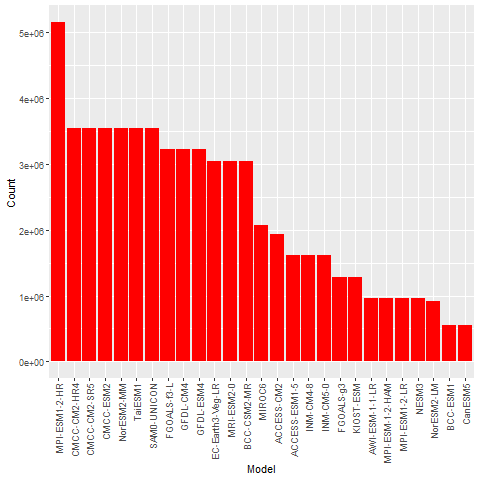

In [21]:
%%R
r_df |> ggplot(aes(x = forcats::fct_infreq(model))) + geom_bar(fill = 'red') + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
labs(x = 'Model',y='Count')    